# Library Imports

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Data Loading

In [4]:
BASE_DIR = Path.cwd().parent
DATA_PATH = BASE_DIR / "Data" / "processed" / "preprocessed.csv"
csv_data = pd.read_csv(DATA_PATH)
csv_data.head()

,MSSubClass,LotFrontage,LotArea,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,SaleCondition_Partial,HouseAge,YearsSinceRemod,Remodeled,TotalArea,HasLotFrontage,LogGrLivArea,LogTotalArea,LogLotArea,SalePrice
0,60,65.0,8450,4,3,7,5,2003,2003,196.0,...,0,5,5,0,4824.0,1,7.444833,8.481566,9.042040,208500
1,20,80.0,9600,4,3,6,8,1976,1976,0.0,...,0,31,31,0,4246.0,1,7.141245,8.353968,9.169623,181500
2,60,68.0,11250,3,3,7,5,2001,2002,162.0,...,0,7,6,1,5100.0,1,7.488294,8.537192,9.328212,223500
3,70,60.0,9550,3,3,7,5,1915,1970,0.0,...,0,91,36,1,4832.0,1,7.448916,8.483223,9.164401,140000
4,60,84.0,14260,3,3,8,5,2000,2000,350.0,...,0,8,8,0,6377.0,1,7.695758,8.760610,9.565284,250000


In [5]:
df = csv_data.copy()

In [6]:
X = df.drop("SalePrice", axis=1)
y = df["SalePrice"]

# Split Data

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [9]:
print(X_train.shape, y_train.shape)

(1168, 233) (1168,)


In [10]:
print(X_test.shape, y_test.shape)

(292, 233) (292,)


# Standardize the data

In [12]:
# Extract columns with numeric data types.
num_cols = X_train.select_dtypes(include = [np.number]).columns

In [13]:
# Filter out flag columns from numerical columns.
flag_cols = [col for col in num_cols if col.endswith("_was_missing") or col.endswith("_nonzero")]

In [14]:
# Remove the flag column from the numeric data columns.
scale_cols = [col for col in num_cols if col not in flag_cols]

In [15]:
# force data to float type
X_train[scale_cols] = X_train[scale_cols].astype(float)
X_test[scale_cols] = X_test[scale_cols].astype(float)

In [16]:
# Standardization
scaler = StandardScaler()
# With training, it will fit_transform
X_train.loc[:, scale_cols] = scaler.fit_transform(X_train[scale_cols])

# With test, it will transform
X_test.loc[:, scale_cols] = scaler.transform(X_test[scale_cols])

In [17]:
# Check if the object data type still exists.
X_train.select_dtypes(include="object").columns

Index([], dtype='object')

In [18]:
X_train[scale_cols].mean().round(2)
X_train[scale_cols].std().round(2)

MSSubClass        1.0
LotFrontage       1.0
LotArea           1.0
LotShape          1.0
LandSlope         1.0
                 ... 
TotalArea         1.0
HasLotFrontage    0.0
LogGrLivArea      1.0
LogTotalArea      1.0
LogLotArea        1.0
Length: 203, dtype: float64

# LinearRegression

In [20]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [21]:
train_score = lr.score(X_train, y_train)
test_score  = lr.score(X_test, y_test)

print("Train R2:", train_score)
print("Test  R2:", test_score)

Train R2: 0.936258829377062
Test  R2: -5.615078797450054e+19


### Coefficient

In [23]:
np.max(np.abs(lr.coef_))

6.102474647362392e+16

### Intercept

In [25]:
lr.intercept_

-8283122712853662.0

### Predict 

In [27]:
y_pred = lr.predict(X_test)

In [28]:
print(f'Thực tế min:{y_test.min()}, Thực tế max:{y_test.max()}')
print(f'Dự đoán min:{y_pred.min()}, Dự đoán max:{y_pred.max()}')

Thực tế min:35311, Thực tế max:755000
Dự đoán min:-1.1080560073342464e+16, Dự đoán max:1612765347511276.0


In [29]:
y_residuals = y_test - y_pred

In [30]:
mae_regress = mean_absolute_error(y_test, y_pred)
rmse_regress = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE:", mae_regress)
print("RMSE:", rmse_regress)

MAE: 45589919513332.47
RMSE: 656273464765275.4


# Ridge

In [32]:
ridge = Ridge(alpha = 1.0)
ridge.fit(X_train, y_train)

Ridge()

In [33]:
ridge_train_score = ridge.score(X_train, y_train)
ridge_test_score  = ridge.score(X_test, y_test)

print("Train R2:", ridge_train_score)
print("Test  R2:", ridge_test_score)

Train R2: 0.9302115731474514
Test  R2: 0.8499109994280141


### Coefficient

In [35]:
np.max(np.abs(ridge.coef_))

95733.14482933587

### Intercept

In [37]:
ridge.intercept_

184141.15943855993

### Predict

In [39]:
y_ridge_pred = ridge.predict(X_test)

In [40]:
print(f'Thực tế min:{y_test.min()}, Thực tế max:{y_test.max()}')
print(f'Dự đoán min:{y_ridge_pred.min()}, Dự đoán max:{y_ridge_pred.max()}')

Thực tế min:35311, Thực tế max:755000
Dự đoán min:-62344.647851928836, Dự đoán max:634439.0471381831


In [41]:
mae_ridge = mean_absolute_error(y_test, y_ridge_pred)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_ridge_pred))

print("MAE:", mae_ridge)
print("RMSE:", rmse_ridge)

MAE: 19800.285064671873
RMSE: 33929.803926604516


In [42]:
# Performance testing with 10 fold
kf = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(ridge, X_train, y_train, cv = kf, scoring = "r2")

print("CV R2 scores:", cv_scores)
print("Mean CV R2:", cv_scores.mean())
print("Std CV R2:", cv_scores.std())

CV R2 scores: [0.83939637 0.92894024 0.86903596 0.70096368 0.66093904 0.7709518
 0.85992515 0.90386108 0.88893098 0.61747477]
Mean CV R2: 0.8040419080756964
Std CV R2: 0.10410212292735725


### Actual and Predict

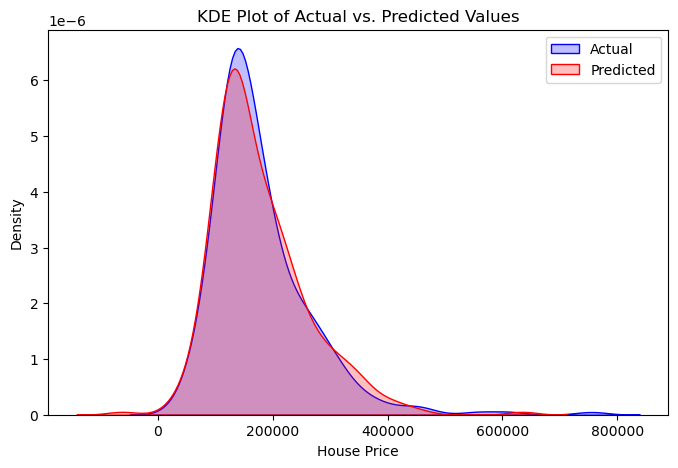

In [44]:
plt.figure(figsize=(8, 5))
sns.kdeplot(y_test, label='Actual', fill=True, color='blue')
sns.kdeplot(y_ridge_pred, label='Predicted', fill=True, color='red')
plt.xlabel('House Price')
plt.ylabel('Density')
plt.title('KDE Plot of Actual vs. Predicted Values')
plt.legend()
plt.show()

### Residual Plot

In [46]:
residual = y_test - y_ridge_pred

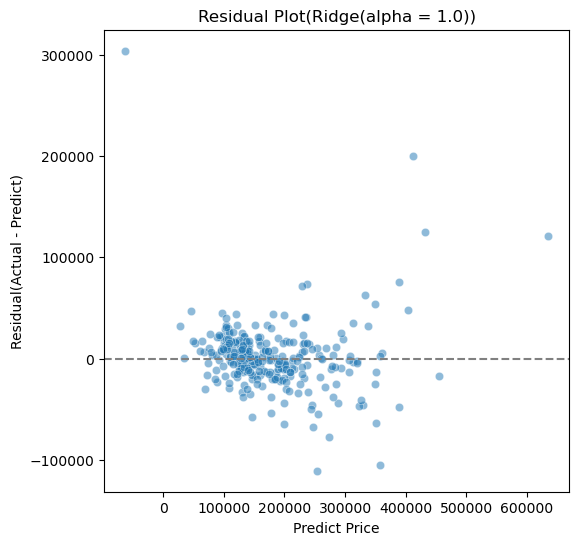

In [47]:
plt.figure(figsize = (6,6))
sns.scatterplot(x = y_ridge_pred, y = residual, alpha = 0.5)
plt.axhline(0, color = 'gray', linestyle = '--')
plt.xlabel("Predict Price")
plt.ylabel("Residual(Actual - Predict)")
plt.title("Residual Plot(Ridge(alpha = 1.0))")
plt.show()

# GridSearchCV

In [49]:
ridges  = Ridge(random_state=42)
alphas = np.logspace(-3,3,30)

grid = GridSearchCV(ridges, param_grid = {'alpha': alphas}, cv = kf, scoring = 'r2', n_jobs = -1)
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Ridge(random_state=42), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-03, 1.61026203e-03, 2.59294380e-03, 4.17531894e-03,
       6.72335754e-03, 1.08263673e-02, 1.74332882e-02, 2.80721620e-02,
       4.52035366e-02, 7.27895384e-02, 1.17210230e-01, 1.88739182e-01,
       3.03919538e-01, 4.89390092e-01, 7.88046282e-01, 1.26896100e+00,
       2.04335972e+00, 3.29034456e+00, 5.29831691e+00, 8.53167852e+00,
       1.37382380e+01, 2.21221629e+01, 3.56224789e+01, 5.73615251e+01,
       9.23670857e+01, 1.48735211e+02, 2.39502662e+02, 3.85662042e+02,
       6.21016942e+02, 1.00000000e+03])},
             scoring='r2')

In [50]:
grid.best_params_

{'alpha': 385.6620421163472}

In [51]:
grid.best_score_

0.8387014176791003

In [52]:
best_ridge = grid.best_estimator_

print("Final Train R2:", best_ridge.score(X_train, y_train))
print("Final Test  R2:", best_ridge.score(X_test, y_test))

Final Train R2: 0.8878949605342829
Final Test  R2: 0.8645777852053169


### Predict

In [54]:
y_grid_pred = best_ridge.predict(X_test)

In [55]:
print(f'Thực tế min:{y_test.min()}, Thực tế max:{y_test.max()}')
print(f'Dự đoán min:{y_grid_pred.min()}, Dự đoán max:{y_grid_pred.max()}')

Thực tế min:35311, Thực tế max:755000
Dự đoán min:24950.824625524314, Dự đoán max:487135.4035836204


In [56]:
mae = mean_absolute_error(y_test, y_grid_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_grid_pred))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 19095.4891123154
RMSE: 32229.37422872156


In [57]:
residuals = y_test - y_grid_pred 

## Actual and Predict 

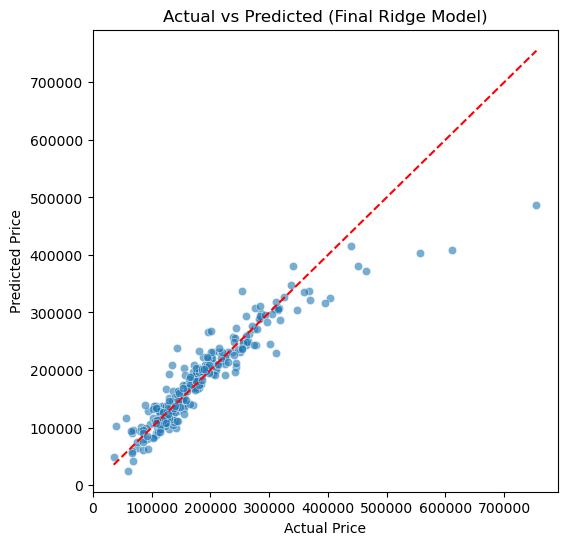

In [59]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_grid_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--') # y = x
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted (Final Ridge Model)")
plt.show()

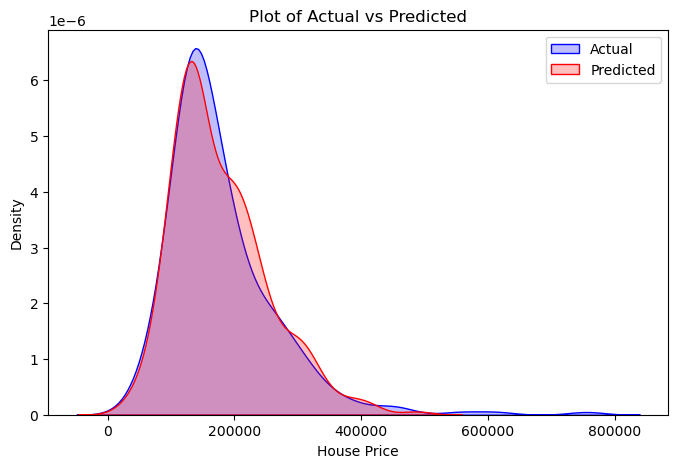

In [60]:
plt.figure(figsize=(8, 5))
sns.kdeplot(y_test, label='Actual', fill=True, color='blue')
sns.kdeplot(y_grid_pred, label='Predicted', fill=True, color='red')
plt.xlabel('House Price')
plt.ylabel('Density')
plt.title('Plot of Actual vs Predicted')
plt.legend()
plt.show()

## Residual Plot

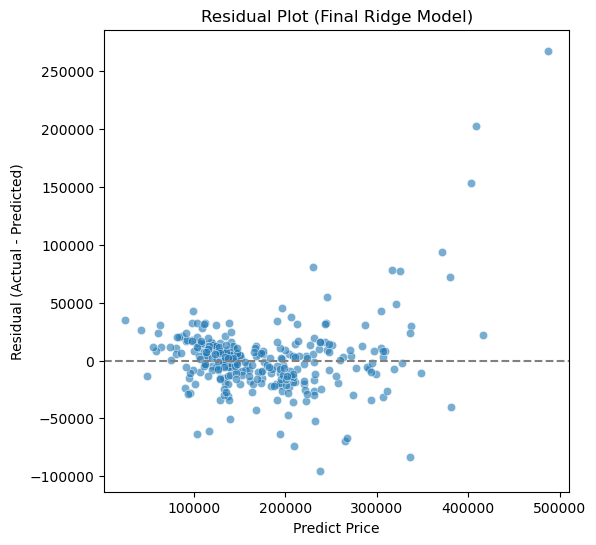

In [62]:
plt.figure(figsize=(6,6))
sns.scatterplot(x = y_grid_pred, y = residuals, alpha = 0.6)
plt.axhline(0, color = 'gray', linestyle = '--')
plt.xlabel('Predict Price')
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot (Final Ridge Model)")
plt.show()

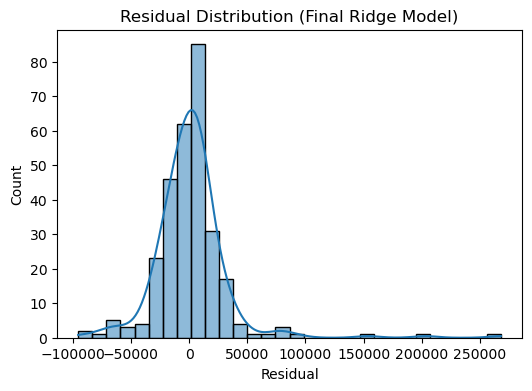

In [63]:
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel("Residual")
plt.title("Residual Distribution (Final Ridge Model)")
plt.show()

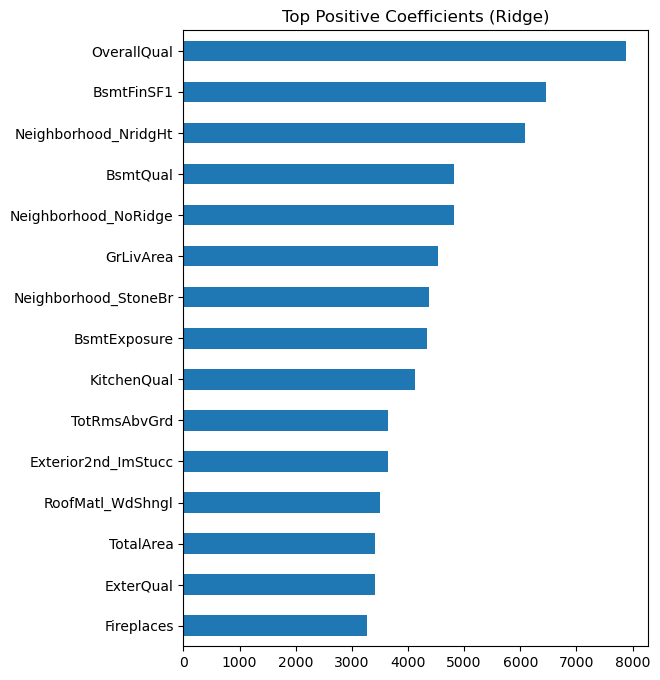

In [64]:
coef = pd.Series(best_ridge.coef_, index=X_train.columns).sort_values()

plt.figure(figsize=(6,8))
coef.tail(15).plot(kind="barh")
plt.title("Top Positive Coefficients (Ridge)")
plt.show()